In [1]:
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

import torchmetrics

import lightly

import matplotlib.pyplot as plt
import numpy as np

/home/shatz/miniconda3/envs/morebetter2/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
/home/shatz/miniconda3/envs/morebetter2/lib/python3.8/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.15. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.16
  warnings.warn(Warning(warning))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# DATA

In [5]:
# data params
num_workers = 6
batch_size = 1

In [6]:
path_to_train = './data/cifar10_lightly/train/'
path_to_test = './data/cifar10_lightly/test/'

In [7]:
# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [8]:
val_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

@TODO: make data for classifier and for moco

... will probably have to make a custom loader that makes both something for moco and something for classifier

# MOCO data

In [9]:
# ive made this file because the standard BaseCollateFunction from lightly
# only supports returning x0 and x1 augmentations for some image x. I also want x returned
# to send to the classifier and to add the reconstruction gradient to
from myCollate import BetterSimCLRCollateFunction

In [10]:
og_img_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

In [11]:
# MoCo v2 uses SimCLR augmentations, additionally, disable blur
# collate_fn = lightly.data.SimCLRCollateFunction(
#     input_size=32,
#     gaussian_blur=0.,
# )

collate_fn = BetterSimCLRCollateFunction(
    input_size=32,
    gaussian_blur=0.
)

In [12]:
# We use the moco augmentations for training moco
dataset_train_moco = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    # transform = og_img_transforms
)

In [13]:
dataloader_train_moco = torch.utils.data.DataLoader(
    dataset_train_moco,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

# Classifier

In [14]:
# model params
n_classes=10
pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"

In [15]:
from plr18 import plr18

In [16]:
model = plr18().load_from_checkpoint(pretrained_model);

In [17]:
model.to(device);
model.eval();

# Defense model

In [18]:
memory_bank_size = 4096

In [19]:
class MocoModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = lightly.models.ResNetGenerator('resnet-18', 1, num_splits=8)
        backbone = nn.Sequential(
            *list(resnet.children())[:-1],
            nn.AdaptiveAvgPool2d(1),
        )

        # create a moco based on ResNet
        self.resnet_moco = \
            lightly.models.MoCo(backbone, num_ftrs=512, m=0.99, batch_shuffle=True)

        # create our loss with the optional memory bank
        self.criterion = lightly.loss.NTXentLoss(
            temperature=0.1,
            memory_bank_size=memory_bank_size)

    def forward(self, x):
        self.resnet_moco(x)

    # We provide a helper method to log weights in tensorboard
    # which is useful for debugging.
    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(
                name, params, self.current_epoch)

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_moco(x0, x1)
        loss = self.criterion(y0, y1)
        self.log('train_loss_ssl', loss)
        return loss

    def training_epoch_end(self, outputs):
        self.custom_histogram_weights()


    def configure_optimizers(self):
        optim = torch.optim.SGD(self.resnet_moco.parameters(), lr=6e-2,
                                momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


In [20]:
moco = MocoModel()

# Experiment

In [21]:
seed = 1
max_epochs = 150
batch_limit = 500

In [22]:
epsilons = [0, 0.001, 0.002, 0.003, 0.004, 0.008, 0.01, .05, .1, .15, .2,]

In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [34]:
def test( model, test_loader, epsilon, batch_limit=1000):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for sample in enumerate(tqdm(dataloader_train_moco)):

        # Send the data and label to the device
        # data, target = data.to(device), target.to(device)
        (idx, (data, tfms, target, _)) = sample

        data = data[0].to(device).unsqueeze(0) # make batch dim
        target = target[0].to(device).unsqueeze(0)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if idx > batch_limit:
            break

    # Calculate final accuracy for this epsilon
    div = min(float(len(test_loader)), float(batch_limit))
    final_acc = correct/div
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, div, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [35]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, val_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 805 / 1000.0 = 0.805


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.001	Test Accuracy = 745 / 1000.0 = 0.745


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.002	Test Accuracy = 677 / 1000.0 = 0.677


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.003	Test Accuracy = 642 / 1000.0 = 0.642


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.004	Test Accuracy = 561 / 1000.0 = 0.561


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.008	Test Accuracy = 418 / 1000.0 = 0.418


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.01	Test Accuracy = 322 / 1000.0 = 0.322


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.05	Test Accuracy = 67 / 1000.0 = 0.067


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.1	Test Accuracy = 59 / 1000.0 = 0.059


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.15	Test Accuracy = 60 / 1000.0 = 0.06


  0%|          | 0/10000 [00:00<?, ?it/s]

Epsilon: 0.2	Test Accuracy = 71 / 1000.0 = 0.071


In [26]:
## SANITY CHECK CODE in case the above doesnt work as expected ##

# correct = 0
# for d, t, _ in tqdm(test_loader):
#     data, target = d.to(device), t.to(device)
#     out = model(data).max(1, keepdim=True)[1]
# #     print('out:', out)
# #     print('target:', target)
    
#     if out.item() == target.item():
#         correct += 1
# print('CORRECT:', correct)


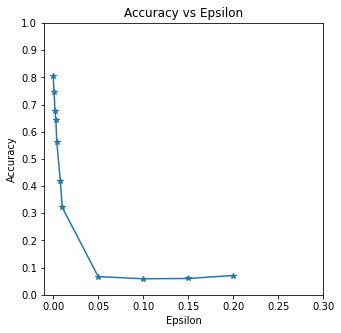

In [36]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Sample Adversarial Examples
~~~~~~~~~~~~~~~~~~~~~~~~~~~

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.




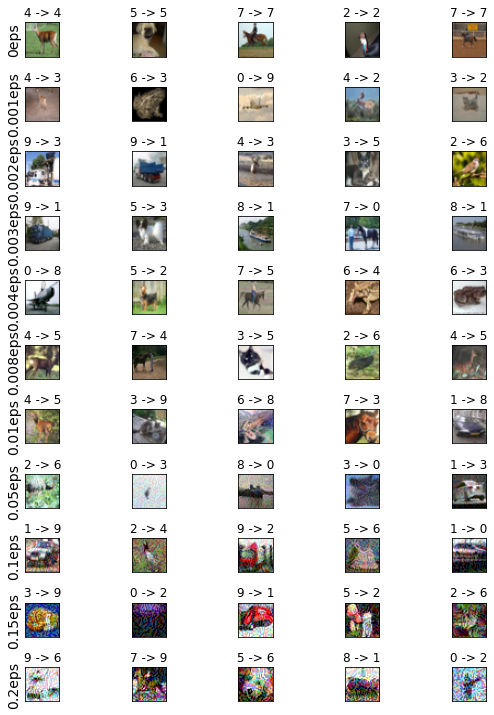

In [37]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("{}eps".format(epsilons[i]), fontsize=14) # eps 
        orig,adv,ex = examples[i][j]
        ex = np.moveaxis(ex, 0, -1)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()